# gRNA Assignment and Merging Replicates

## Loading Packages, Data, and Utility Functions

In [1]:
library(DT)
library(spgs)
library(scran)
library(scater)
library(Seurat)
library(batchelor)
library(tidyverse)
library(data.table)
library(DropletUtils)
library(BiocSingular)
library(EnsDb.Hsapiens.v86)
library(SingleCellExperiment)

options(repr.plot.width=22, repr.plot.height=8)

data_dir = '../data'
gene_metadata = read.csv(paste0(data_dir, '/Metadata/gene_metadata.csv'))

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

## Loading Replicates

In [2]:
grna_meta_cols = c('grna_name', 'Brunello', 'Edwards', 'Yuza', 'different_cut', 'Comments', 'gRNA_Reference')

rep1 = readRDS(paste0(data_dir, '/SCE/Rep1.pre_qc_filtering.Rds'))
rep2 = readRDS(paste0(data_dir, '/SCE/Rep2.pre_qc_filtering.Rds'))

rep1_count = Read10X(paste0(data_dir, '/SCE/grna_barcodes/rep1'), gene.column = 1)
rep2_count = Read10X(paste0(data_dir, '/SCE/grna_barcodes/rep2'), gene.column = 1)

rep1_grna = SingleCellExperiment(list(counts=rep1_count))
rep2_grna = SingleCellExperiment(list(counts=rep2_count))

# loading Edwards gRNA metadata
gene_meta = read.csv(paste0(data_dir, '/Metadata/gene_metadata.csv'))
Edwards_grna_meta = read.csv(paste0(data_dir, '/Metadata/guide_library_key.csv'), col.names=grna_meta_cols)

colnames(gene_meta) = c('Gene_Symbol', 'Category', 'Essentiality')

## Utility Function's

Functions below are used to apply the Crop-Seq Threshold method of identifying gRNAs present in cells. In order to do this I gRNA Barcode Matrix into a dataframe using the `extract_grnas` function. While, I am doing that i am also calculating some useful features such as grna count proportion in a given cell and the total number of reads. 

Next detect the presence of gRNAs in a cells by applying Crop-Seq based threshold detection method. In which, a Cell is declared to have a gRNA if the gRNA has a least 15 UMIs supporting is and accounts for more than 20% of all gRNA reads assigned to a given cell. Additionally, I use the % of unmapped gRNA Reads a measure of uncertainity in our gRNA labels.

Finally, I extract all gRNAs in cells and update cell metadata. Guide information is added to cell metadata if there is only a single gRNA in the cell. If not all of the additionally, information i add i null except for the number of gRNA column and % of unmapped reads.

This pipeline is wrapped around by the `identify_grnas_in_cells` function.

In [7]:
#################### Single Cell Quality Control Utility Code ####################

fetch_mito_genes = function(sce) {
  # extracting Mitochondrial genes for current sce object rownames
  location = mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce)$ID, column="SEQNAME", keytype="GENEID")
  mito = list(Mito = which(location == "MT"))
  return (mito)
}

qc_by_nmad = function(stat){
  # Function calculates QC metrics by using N Median Absolute Deviation (NMAD)
  # Then saves soft labels cells to discard generated stats dataframe and returns stats.
  qc.lib = isOutlier(stat$sum, log=TRUE, type='lower')
  qc.nexpr = isOutlier(stat$detected, log=TRUE, type='lower')
  qc.mito = isOutlier(stat$subsets_Mito_percent, type='higher')
  stat$discard = qc.lib | qc.nexpr | qc.mito
  
  return (stat)
}

#################### gRNA Identification and Assignment Utility Code ####################

identify_grnas_in_cells = function(sce, grna_counts) {
  
  guides_meta = extract_grnas(assay(grna_counts, 'counts'))
  guides_meta = assign_grnas(guides_meta)
  cell_guides = update_guides_metadata(guides_meta)
  cells_meta = update_cell_metadata(colData(sce), guides_meta, cell_guides)
  
  return (list(as.data.frame(cell_guides), as.data.frame(cells_meta), as.data.frame(guides_meta)))
}

extract_grnas = function(grna_count_mat){
    
    grnas = c()
    cells = c()
    counts = c()
    prop = c()
    discard = c()
    cell_total = c()
    
    for (cell in colnames(grna_count_mat)) {
      # extacting cells gRNA counts
      grna_counts = grna_count_mat[, cell]
      grna_counts = grna_counts[which(grna_counts > 0 | names(grna_counts) == 'unmapped')]
      
      # exrtacting features from cell gRNA counts
      grnas = c(grnas, names(grna_counts))
      counts = c(counts, as.vector(grna_counts))
      prop = c(prop, as.vector(grna_counts) / sum(as.vector(grna_counts)))
      cells = c(cells, rep(cell, each=length(grna_counts)))
      cell_total = c(cell_total, rep(sum(as.vector(grna_counts)), each=length(grna_counts)))
    }
    
    all_guides = data.frame(grnas=grnas, Barcode=as.character(cells), umi_counts=counts, proportion=prop, cell_total=cell_total)
    
    return(all_guides)
}

assign_grnas = function(all_guides, umi_thresh=15, percent_thresh=0.20) {
  # Using the Crop-Seq threshold method to detect gRNAs in cells.
  
  assigned = all_guides %>%  
             dplyr::filter(umi_counts > umi_thresh & proportion > percent_thresh | grnas == 'unmapped') %>%
             dplyr::group_by(Barcode) %>%
             dplyr::mutate(crop_seq_class=paste0('gRNAs_#_', length(grnas) - 1),
                       number_of_grnas=length(grnas) - 1)
  
  return (assigned) 
}

update_guides_metadata = function(all_guides) {
  # updating the guides metadata for downstream analysis
  cell_guides = all_guides %>% 
            dplyr::filter(grnas != 'unmapped') %>% 
            dplyr::mutate(grna_name=gsub("-[ACTG]*", "", grnas),
                    gene=str_extract(grnas, '[^_]+'),
                    library=str_extract(grnas,'Yuza|Brunello|Edwards|merge'),
                    grna_seq=gsub("^.*-", "", grnas)) %>%
            dplyr::select(-grnas)
  
  cell_guides[is.na(cell_guides$library), ]$gene = 'Control'
  cell_guides[is.na(cell_guides$library), ]$library = 'Control'
  
  return (cell_guides)
}

update_cell_metadata = function(cell_meta, all_guides, cell_guides) {
    # updating the colData of SCE object so it includes grna in cell, targeted gene, and the library grna is from
    
    all_guides_col_useful = c('Barcode', 'proportion', 'cell_total', 'number_of_grnas', 'crop_seq_class')
    useless_sce_cols = c("GuideName", "Library", "Gene", "gRNA.Library")
    
    unmapped = data.table(all_guides[all_guides$grnas == 'unmapped', all_guides_col_useful])
    # cell_meta[!cell_meta$Cell.Calssification %in% c('Doublet', 'Negative'), ]$Cell.Classification = 'Single'
    cell_meta = as.data.table(cell_meta[, !names(cell_meta) %in% useless_sce_cols])
    
    single_grnas = cell_guides %>% 
                      dplyr::filter(number_of_grnas == 1) %>% 
                      dplyr::select(Barcode, gene, grna_name, library)
        
    cell_meta = left_join(cell_meta, unmapped, by='Barcode')
    cell_meta = left_join(cell_meta, single_grnas, by='Barcode')
    
    cell_meta[!cell_meta$Cell.Classification %in% c('Negative', 'Doublet'), ]$Cell.Classification = 'Single'
    
    return (cell_meta)
}

#################### Creating Duplicate Cells for gRNAs that are shared between multiple libraries. Specifically, create 1 duplicate cell per library ####################

extract_grna_sequences = function(cells_meta, grna_mat_fp){
  grna_seqs = c()
  grna_names = c()
  grna_count = Read10X(grna_mat_fp, gene.column = 1)
  grna_barcodes = str_split(rownames(grna_count), '-')
  
  for (grna_vector in grna_barcodes) {
    split_length = length(grna_vector)
    
    if (split_length == 3) {
      grna_vector = c(paste0(grna_vector[1], grna_vector[2]), grna_vector[3])
    }
    
    if (grna_vector[1] != 'unmapped'){
      grna_seq = tail(grna_vector,  n=1)
      grna_names = c(grna_names, grna_vector[1])
      grna_seqs = c(grna_seqs, toupper(reverseComplement(grna_vector[2])))
    }
  }
  
  # add guide RNA sequence to the single cell metadata. This is important to merge gRNA metadata
  grna_barcodes = data.frame(grna_name=grna_names, guideSeq=grna_seqs)
  cells_meta = dplyr::left_join(cells_meta, grna_barcodes, by='grna_name')
  
  return (cells_meta)
}

creating_dup_cells_per_library = function(cell_meta, grna_meta, libraries=c('Brunello', 'Edwards', 'Yuza')) {
    temp_cell_meta = data.frame()

    for (i in 1:nrow(cell_meta)) {
        # extract individual cell and gRNA specific metadata 
        cell = cell_meta[i, ]
        grna = grna_meta %>% dplyr::filter(grna_name == cell$grna_name)
        
        for (lib in libraries) {
            is_present = grna[, lib]
            
            if (is_present == 1) {
                dup = cell 
                dup$library = lib
                dup$grna_name = paste0(cell$grna_name, '_', lib)
                temp_cell_meta = rbind(temp_cell_meta, dup)   
            }
        }
    }
    
    return (temp_cell_meta)
}

#################### Create a KO efficiency plot ####################

ko_efficiency_plot = function(controlcells, sgene, mat, colmetadata, handpicked_null_genes){
  
  pvalues = c()
  silent_genes = c()
  effect_genes = c()
  null_genes = handpicked_null_genes
  
  for (sgene in sgenes) {
    
      for (egene in sgenes){
        
         if (sgene %in% rownames(mat)) {
            perturbcells = which(colmetadata$gene %in% sgene)
            controldist = mat[egene, controlcells]
            
            guidedist = mat[egene, perturbcells]
            pval = t.test(controldist, guidedist)$p.value
            
            silent_genes = c(silent_genes, sgene)
            effect_genes = c(effect_genes, egene)
            pvalues = c(pvalues, pval)
            
            if (is.nan(pval) & sgene == egene){
              null_genes = c(null_genes, sgene)
            }
         }
      }
  }
  
  # removing genes with expression thresholds below zero. This is defined as genes that had zero counts in both ctrl and perturbed cells.
  pvalues = log10(pvalues)
  ko_df = data.frame(pvalues, silent_genes, effect_genes)
  ko_df = ko_df[!ko_df$silent_genes %in% null_genes & !ko_df$effect_genes %in% null_genes, ]
  ko_df[is.na(ko_df$pvalues), ]$pvalues = 0
  ko_df[ko_df$pvalues < -5, ]$pvalues = -5
  
  ggplot(ko_df, aes(x=silent_genes, y=effect_genes, fill=pvalues)) + 
    geom_tile() + 
    scale_fill_distiller(palette = "RdPu") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), panel.background = element_rect(fill = 'white')) + 
    labs(x='Target Genes', y='Target Genes', title='Assessing KO Efficiency of Target Genes via Expression')
}

# Exploring Batch Effects between Replicates

In the following sections of code I assess how much batch effects there is in the data. In order to assess batch effects you need to model gene variance and identify the genes with the highest variance. Once you have this data you then take the intersect between the replicates. Fortunately, there appears to be a high overlap in observed genes between replicates. Then you conduct multi batch normalization via batchelor and merge replicates into one SCE object. Finally, conduct PCA to merged SCE and visualize differences between batches via T-SNE.

## Identifying gRNAs in Cells

Running Crop-Seq Threshold Method on both replicates and then creating new SingleCellExperiment Objects to store the results in.

In [8]:
# Replicate 1
rep1_all = identify_grnas_in_cells(rep1, rep1_grna)
rep1_guide = rep1_all[[1]]
rep1_cell = rep1_all[[2]]
rep1_all = rep1_all[[3]]
rownames(rep1_cell) = rep1_cell$barcode

# creating a new SCE object with the gRNA assignments
rep1_assign = SingleCellExperiment(assays=list(counts=assay(rep1, 'counts')),
                                  colData=rep1_cell,
                                  rowData=rowData(rep1))

rownames(rep1_assign) = rownames(rep1)

# Replicate 2
rep2_all = identify_grnas_in_cells(rep2, rep2_grna)
rep2_guide = rep2_all[[1]]
rep2_cell = rep2_all[[2]]
rep2_all = rep2_all[[3]]

# creating a new SCE object with the gRNA assignments
rep2_assign = SingleCellExperiment(assays=list(counts=assay(rep2, 'counts')),
                                   colData=rep2_cell,
                                   rowData=rowData(rep2))

rownames(rep2_assign) = rownames(rep2)

## First Applying Normalization to Cell Libraries

I am conducting library normalization via deconvolution. Deconvolution is where libraries of a similar size is grouped together and then normalize them together. This allows us to take into account difference in library size effect on transcriptional count data. Allowing for more accurate assessment of differential expression and gene variation. 

In [9]:
set.seed(100)
reps = list(replicate_1=rep1_assign, replicate_2=rep2_assign)

for (n in names(reps)){
    sce = reps[[n]]
    clust = quickCluster(sce)
    sce = computeSumFactors(sce, cluster=clust, min.mean=0.1)
    sce = logNormCounts(sce)
    
    reps[[n]] = sce
}

## Second Modelling Gene Variance and Identifying High Variance Genes

I model gene variance of the normalized log-counts of the replicates. This method of modelling gene variance assumes that genes with the largest variance in log-values will contribute the most to the Euclidean distance between cells. This is most relevant for assessing systematic differences in gene expression between our MCF7 replicates. Finally, I simply take the top 10% of high variance genes.

Once we have a high variance gene list will need to find the intersect of genes and high variance genes between the replicates. This ensures there are no differences in the matrix dimension of our replicates. Enabling us to merge replicates together.

In [10]:
all.dec = lapply(reps, modelGeneVar)
all.hvgs = lapply(all.dec, getTopHVGs, prop=0.1)

rep1_assign = reps$replicate_1
dec_rep1 = all.dec$replicate_1

rep2_assign = reps$replicate_2
dec_rep2 = all.dec$replicate_2

In [11]:
universe = intersect(rownames(rep1_assign), rownames(rep2_assign))

rep1_assign = rep1_assign[universe, ]
rep2_assign = rep2_assign[universe, ]

dec_rep1 = dec_rep1[universe,]
dec_rep2 = dec_rep2[universe,]

combined.dec = combineVar(dec_rep1, dec_rep2)
chosen.hvgs = combined.dec$bio > 0

## Third Multi Batch Normalization and Visualization

Once we have selected the intersect gene space between replicates we can normalize across multiple batches and then conduct dimensionality reduction to visualize our data. During multiple batch normalizations our log-normalized values are adjusted by size factors that take into account systematic differences in coverage between our replicates. Thereby, removing noise from our replicates count data. Finally, we apply Priniciple Component Analysis (PCA) to our merged data.

In [12]:
cols = colnames(colData(rep2_assign))[colnames(colData(rep2_assign)) != "Category"]
colData(rep2_assign) = colData(rep2_assign)[, cols]
  
rescaled = multiBatchNorm(rep1_assign, rep2_assign)

rep1_assign = rescaled[[1]]
rep2_assign = rescaled[[2]]

rowData(rep1_assign) = rowData(rep2_assign)

rep1_assign$batch = "rep1"
rep2_assign$batch = "rep2"

merged = cbind(rep1_assign, rep2_assign)
merged = runPCA(merged, name='all', BSPARAM=BiocSingular::RandomParam())

## Fourth Visualization via T-SNE

Using the PCA conducted our merge data we can finally visualize our batch effects. From observing the plots there appears to be no major biases effect either replicate. In fact, our replicates appear to perfectly overlap. Most likely this is because our replicates are from cell lines.

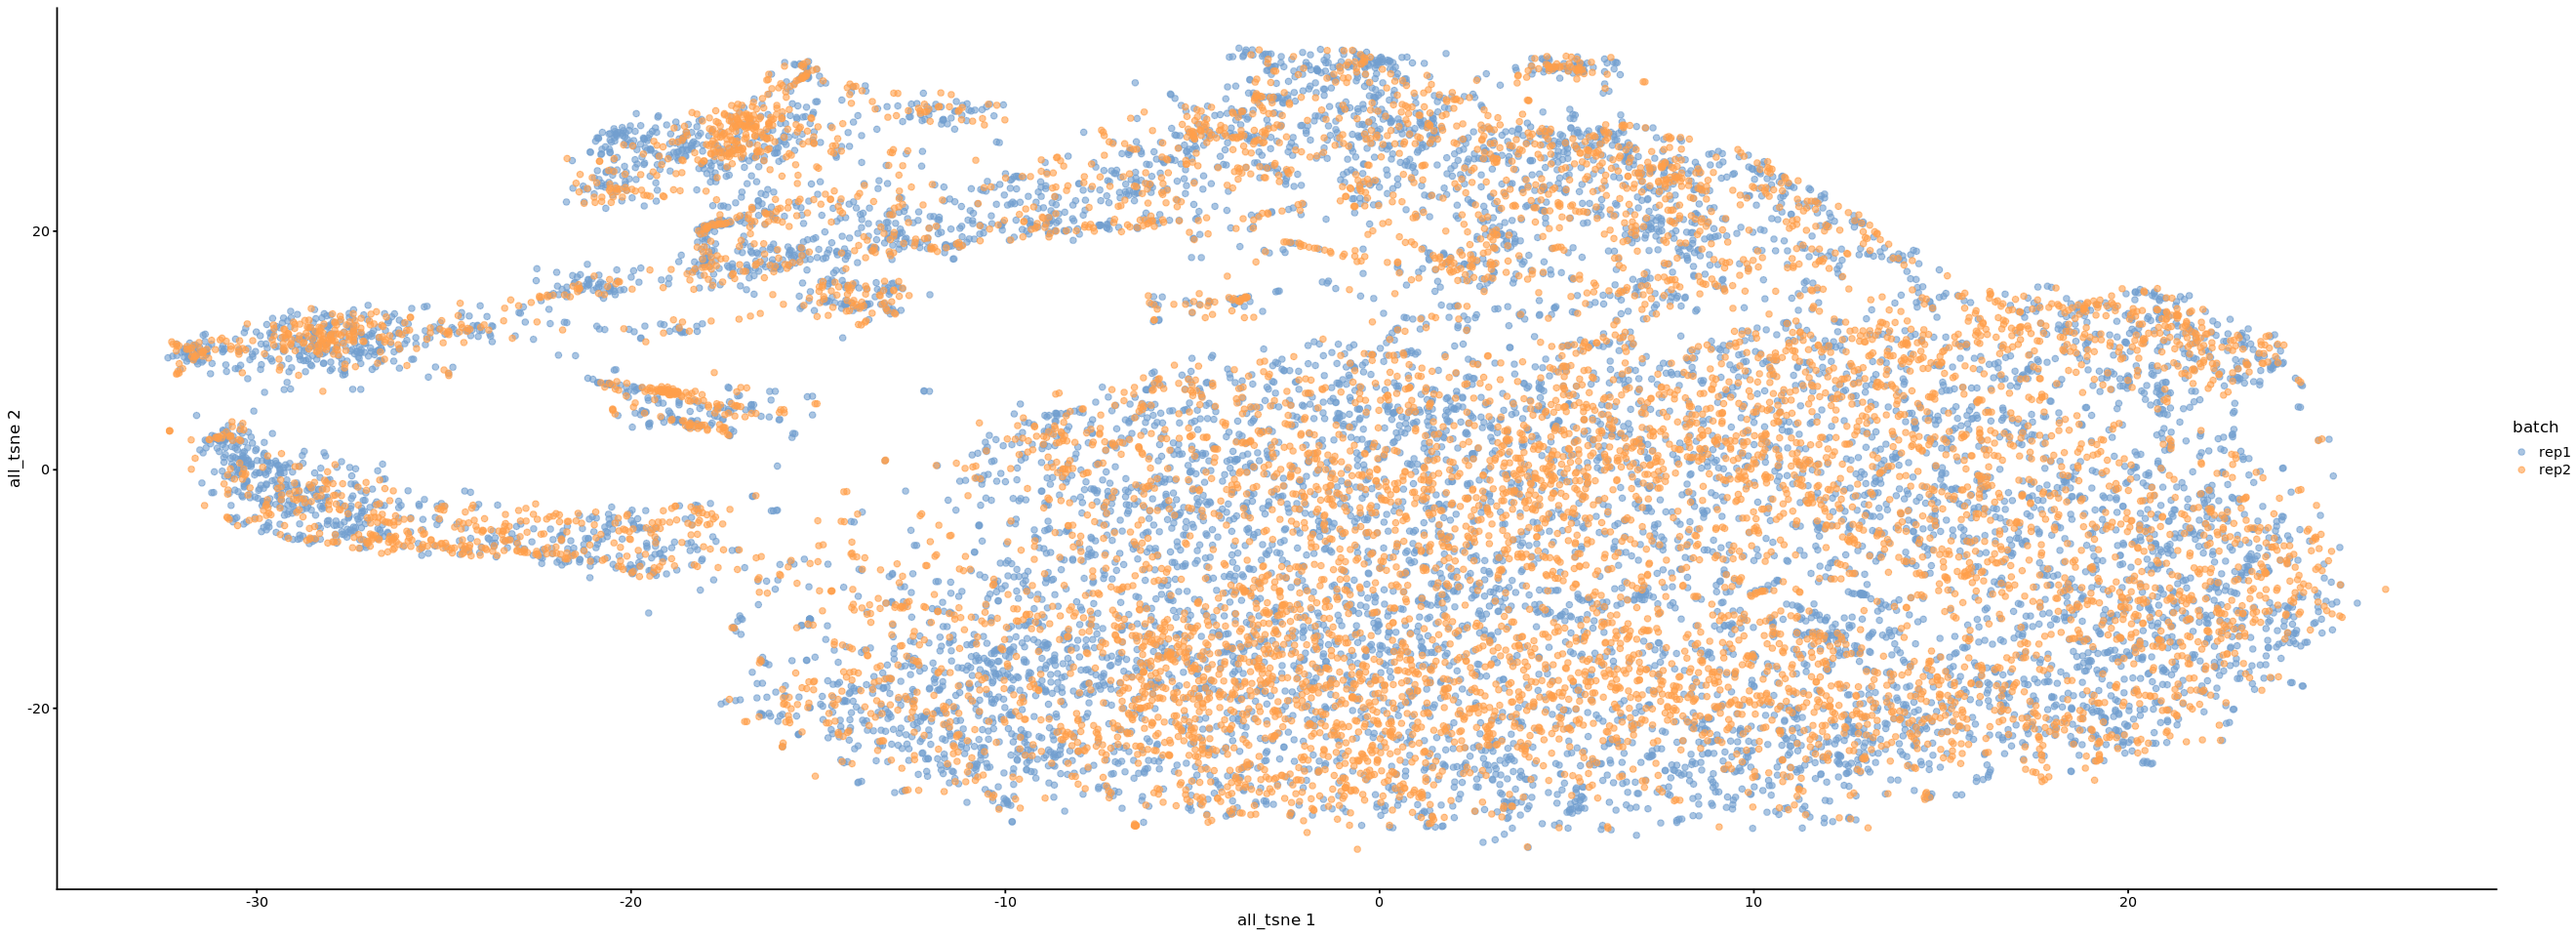

In [13]:
set.seed(1111001)
merged = runTSNE(merged, name='all_tsne', dimred="all")

# visualizing T-SNE
plotReducedDim(merged, dimred='all_tsne', colour_by="batch")

In [14]:
is.mito = fetch_mito_genes(merged)

# calculate cell QC metrics and assign discard labels
stat = perCellQCMetrics(merged, subsets=is.mito)
stat = qc_by_nmad(stat)

colData(merged) = cbind(colData(merged), stat)

Warning message:
"Unable to map 312 of 33538 requested IDs."


# Quality Control of Merged SCE data

## Visualizing Distribution of Individual Quality Control Metrics

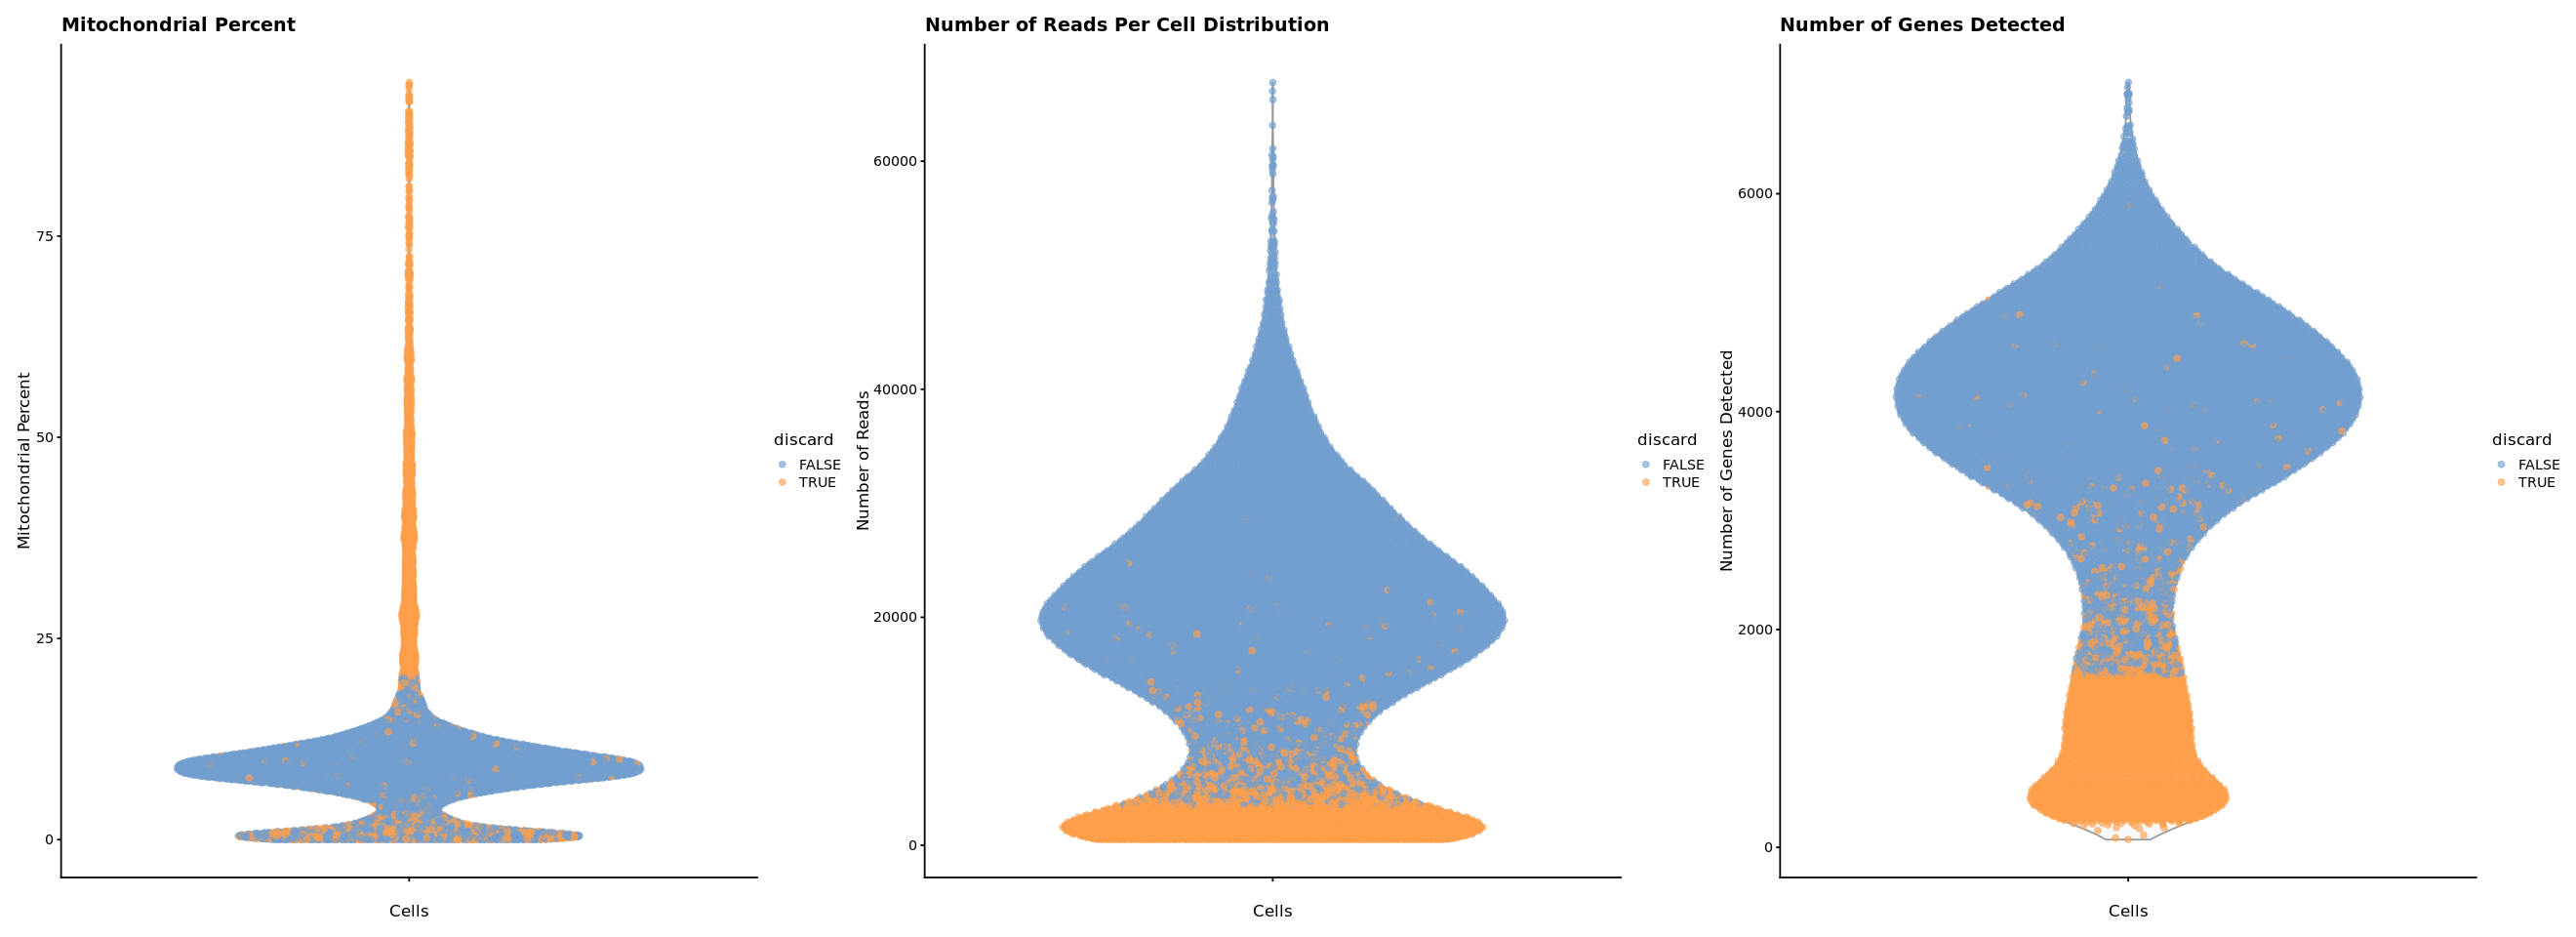

In [15]:
x_label = "Cells"

mito_plot = plotColData(merged, y='subsets_Mito_percent', colour_by = 'discard') +
                labs(title="Mitochondrial Percent", x=x_label, y='Mitochondrial Percent')

cell_count_plot = plotColData(merged, y='sum', colour_by = 'discard') +
                    labs(title="Number of Reads Per Cell Distribution", x=x_label, y='Number of Reads')

num_of_gene_detect_plot = plotColData(merged, y='detected', colour_by = 'discard') + 
                            labs(title="Number of Genes Detected", x=x_label, y='Number of Genes Detected')

mito_plot | cell_count_plot | num_of_gene_detect_plot

## Visualizing Relationships between Quality Control Metricss

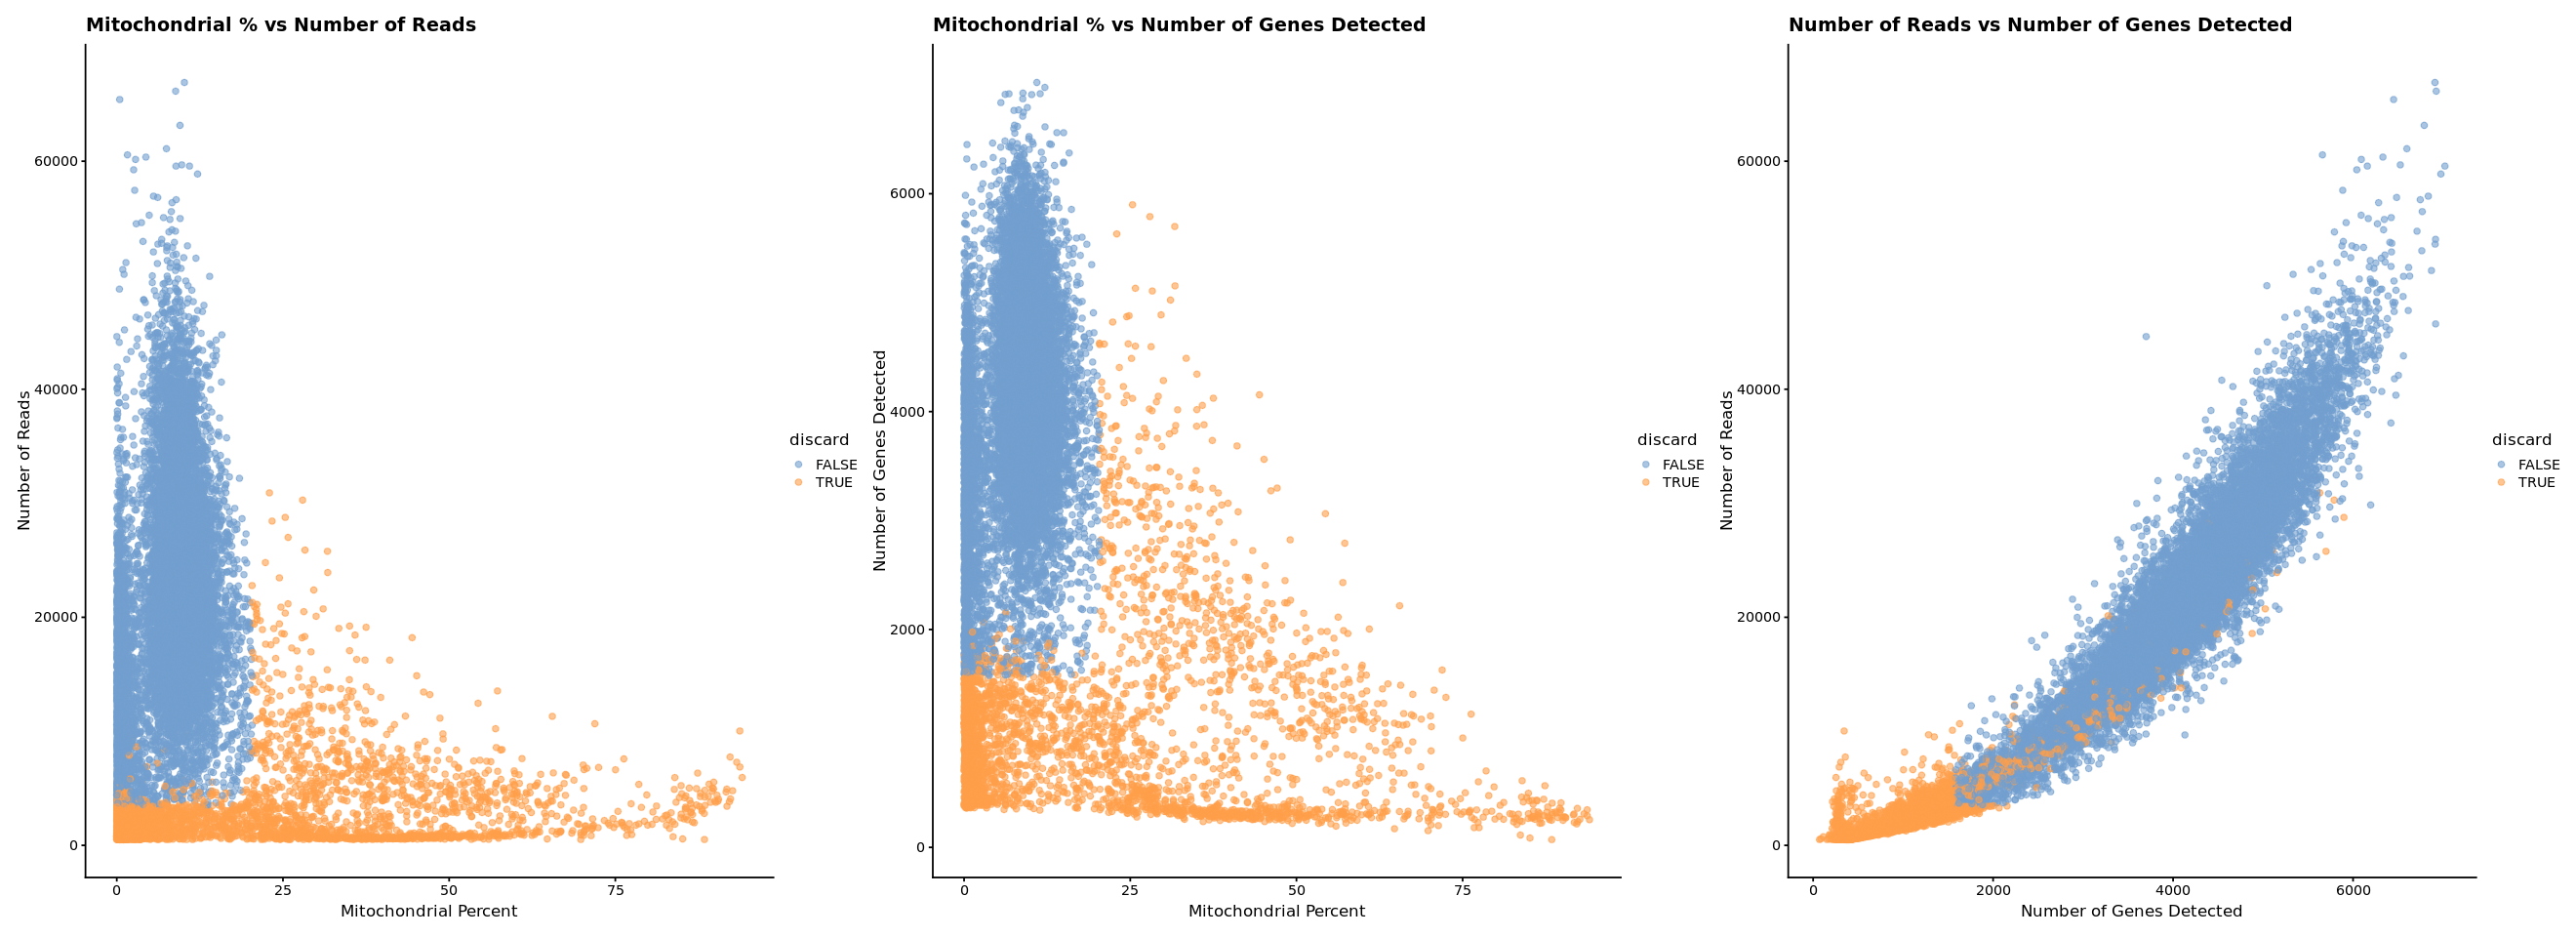

In [16]:
count_mito_plot = plotColData(merged, y='sum', x='subsets_Mito_percent', colour_by = 'discard') +
                    labs(title="Mitochondrial % vs Number of Reads", y='Number of Reads', x='Mitochondrial Percent')

gene_detect_mito_plot = plotColData(merged, y='detected', x='subsets_Mito_percent', colour_by = 'discard') +
                            labs(title="Mitochondrial % vs Number of Genes Detected", y='Number of Genes Detected', x='Mitochondrial Percent')

count_gene_detect_plot = plotColData(merged, y='sum', x='detected', colour_by = 'discard') +
                            labs(title="Number of Reads vs Number of Genes Detected", y='Number of Reads', x='Number of Genes Detected')

count_mito_plot | gene_detect_mito_plot | count_gene_detect_plot

# gRNA Quality Control - Cells that passed QC

In the following sections of code i am exploring what kind of cells were filtered from the dataset. How much does this effect the my downstream anaylsis? Are there gRNAs are enriched in the filtered cells? Fortunately based on plot below it looks like the majority of cells we filtered we failed to label with a particular gRNA. However, i must stress that we don't know what this means are the majority of these cell's don't have there gRNA labels. There maybe hidden correlations between gRNA label and QC metrics.

## Number of Cells by Crop-Seq Threshold Class of gRNA detection method

The figure belows how many cells belong to each Crop-Seq Threshold Class. I then colored how many cells would be discarded based on normal single cell QC methods. Looking at the figure below it looks like that the majority of cells we couldn't identify a gRNA in are failed QC. Though there are a few hundred cells with 1 gRNA and about 100 of cells with 2 gRNA that failed QC. Overall, i would argue that this looks really good and we have some high quality data there.

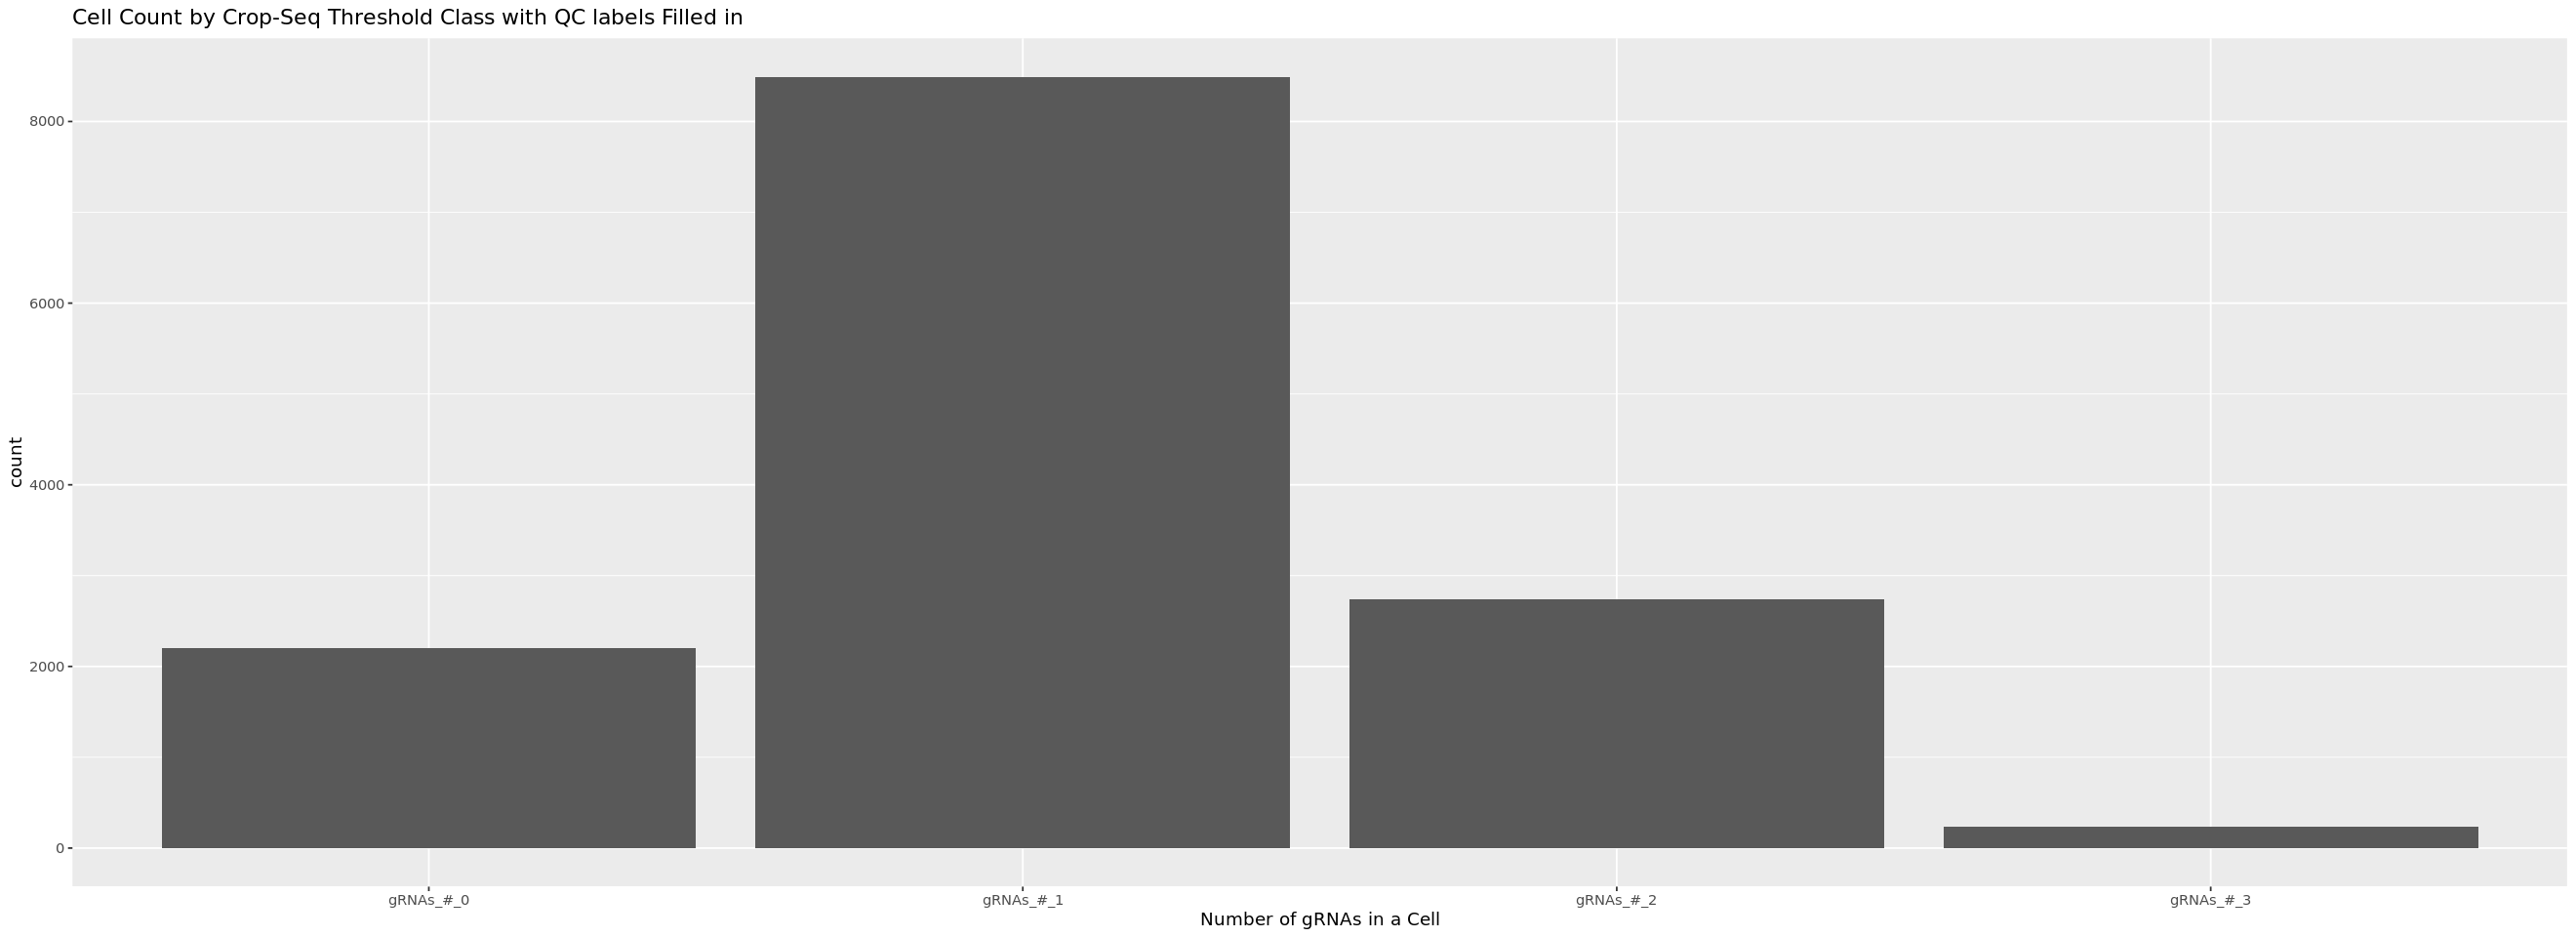

In [22]:
colData(merged) %>%
    as.data.frame %>% 
    dplyr::filter(number_of_grnas != 4 & !discard) %>%
    ggplot(aes(x=crop_seq_class)) +
    geom_bar() +
    labs(title = 'Cell Count by Crop-Seq Threshold Class with QC labels Filled in', x = 'Number of gRNAs in a Cell')

## Grouping Cells by gRNA library

In [26]:
# Extract cells with only 1 gRNA and create duplicate cells for gRNAs shared between multiple libraries
sce = merged[, merged$number_of_grnas == 1]

meta = as.data.frame(colData(sce))
meta = extract_grna_sequences(meta, '../data/SCE/grna_barcodes/rep2')

unique_meta = meta %>% dplyr::filter(library != 'merge')
shared_meta = meta %>% dplyr::filter(library == 'merge')

dup_meta = creating_dup_cells_per_library(shared_meta, Edwards_grna_meta)
cell_meta = rbind(unique_meta, dup_meta)

In [27]:
# extracting cell metadata
yuza = cell_meta %>% dplyr::filter(library %in% c('Yuza', 'Control'))
edwards = cell_meta %>% dplyr::filter(library %in% c('Edwards', 'Control'))
brunello = cell_meta %>% dplyr::filter(library %in% c('Brunello', 'Control'))

# creating sce object
yuza_sce = sce[, yuza$Barcode]
edwards_sce = sce[, edwards$Barcode]
brunello_sce = sce[, brunello$Barcode]

# yuza$gene = factor(yuza$gene, levels=gene_meta$Gene_Symbol)
# edwards$gene = factor(edwards$gene, levels=gene_meta$Gene_Symbol)
# brunello$gene = factor(brunello$gene, levels=gene_meta$Gene_Symbol)

## Visualizing gRNA Detection rates and Number of Cells with a gRNA per Gene

In the following section of code i first filter out all doublet and negative labeled cells. Then i cleaned the metadata of cells with only one gRNA in order to visualize the number gRNAs i detected along with the number of cells that contain an individual gRNA.

In [28]:
level_order = c('Yuza', 'Brunello', 'Edwards')
cells_gene = cell_meta %>% dplyr::filter(library != 'Control') %>% group_by(library, gene) %>% tally()
cells_grna = cell_meta %>% dplyr::filter(library != 'Control') %>% group_by(library, grna_name) %>% tally()


yuza_gene = cells_gene[cells_gene$library == 'Yuza',]
edwards_gene = cells_gene[cells_gene$library == 'Edwards',] 
brunello_gene = cells_gene[cells_gene$library == 'Brunello',]

yuza_grna = cells_grna[cells_grna$library == 'Yuza',]
edwards_grna = cells_grna[cells_grna$library == 'Edwards',] 
brunello_grna = cells_grna[cells_grna$library == 'Brunello',]

edwards_vs_yuza_grna = round(wilcox.test(edwards_grna$n, yuza_grna$n)$p.value, 2)
brunello_vs_yuza_grna = round(wilcox.test(brunello_grna$n, yuza_grna$n)$p.value, 2)
edwards_vs_brunello_grna = round(wilcox.test(edwards_grna$n, brunello_grna$n)$p.value, 2)

edwards_vs_yuza_gene = round(wilcox.test(edwards_gene$n, yuza_gene$n)$p.value, 2)
brunello_vs_yuza_gene = round(wilcox.test(brunello_gene$n, yuza_gene$n)$p.value, 2)
edwards_vs_brunello_gene = round(wilcox.test(edwards_gene$n, brunello_gene$n)$p.value, 2)

Warning message in wilcox.test.default(edwards_gene$n, yuza_gene$n):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(brunello_gene$n, yuza_gene$n):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(edwards_gene$n, brunello_gene$n):
"cannot compute exact p-value with ties"


In [29]:
level_order = c('Yuza', 'Brunello', 'Edwards')
cells_gene = cell_meta %>% dplyr::filter(library != 'Control') %>% group_by(library, gene) %>% tally()
cells_grna = cell_meta %>% dplyr::filter(library != 'Control') %>% group_by(library, grna_name) %>% tally()

gene_box = cells_gene %>% 
                ggplot(aes(x=factor(library, level=level_order), y=n, fill=library)) +
                geom_boxplot() +
                ylim(0, 250) +
                theme_bw() +
                theme(plot.background = element_blank(),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      panel.border = element_blank(),
                      axis.line = element_line(color = 'black')) +
                ylab('Cells per Target Gene') +
                xlab('guide RNA Library') + 
                annotate(geom="text", x=2, y=250, label="Edwards vs Brunello: 0.15") +
                annotate(geom="text", x=1, y=250, label="Edwards vs Yuza: 0.64")

grna_box = cells_grna %>% 
            ggplot(aes(x=factor(library, level=level_order), y=n, fill=library)) +
            geom_boxplot() +
            theme_bw() +
            theme(plot.background = element_blank(),
                  panel.grid.major = element_blank(),
                  panel.grid.minor = element_blank(),
                  panel.border = element_blank(),
                  axis.line = element_line(color = 'black')) +
            ylab('Cells per guide RNA') +
            xlab('guide RNA Library') + 
            annotate(geom="text", x=2, y=120, label="Edwards vs Brunello: 0.52") +
            annotate(geom="text", x=1, y=120, label="Edwards vs Yuza: 0.11")

ggsave("cell_per_gene_boxplot.eps", plot=gene_box, height=8, width=8, units="in",device = "eps")
ggsave("cell_per_grna_boxplot.eps", plot=grna_box, height=8, width=8, units="in",device = "eps")

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


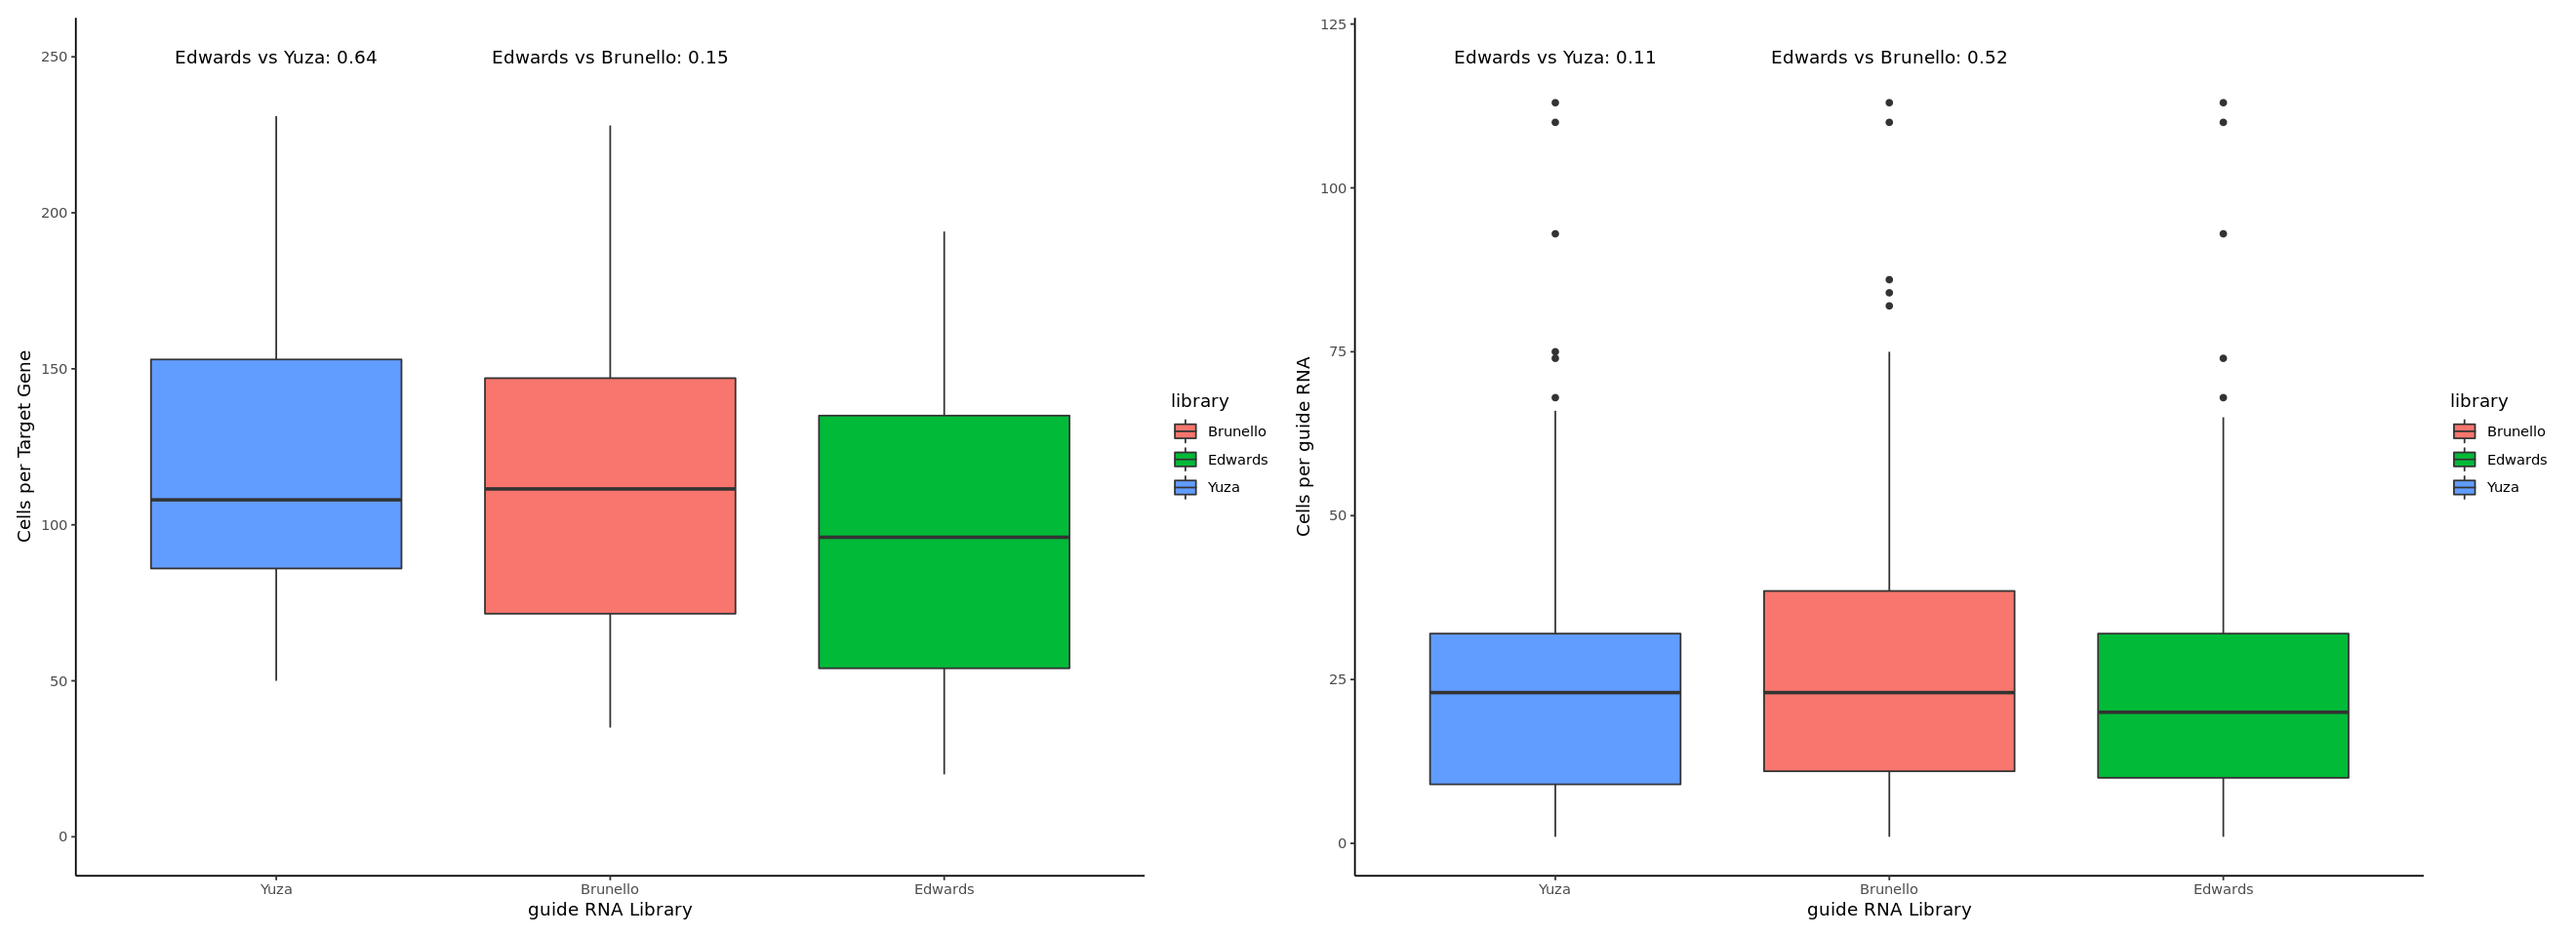

In [30]:
gene_box | grna_box 

In [31]:
colnames(gene_metadata) <- c('Gene_Symbol', 'Category', 'Essentiality')
genes_for_level <- gene_metadata %>% map_df(rev) %>% pull(Gene_Symbol)

In [32]:
genes_levels <- c('TFAP2C','MYC','GATA3','MTOR','CCND1','SMC1A','ESR1',
                  'FOXA1','NCOA3','CREBBP','MED1','MED12','AKT1','SMARCA4',
                  'EP300','CARM1','TP53','NCOA5', 'RB1', 'E2F1', 'ACCSL','MEP1A',
                  'IRGC','NPSR1','PNPLA5','BPIFB3','GDF2','SPATA16','CLDN17','FCRL4')

yuza$gene = factor(yuza$gene, levels=genes_levels)
edwards$gene = factor(edwards$gene, levels=genes_levels)
brunello$gene = factor(brunello$gene, levels=genes_levels)

temp_meta <- cell_meta %>%
                dplyr::group_by(library, gene) %>% 
                dplyr::filter(library != 'Control') %>%
                dplyr::summarise(gRNA_per_Gene = n_distinct(grna_name))

`summarise()` has grouped output by 'library'. You can override using the
`.groups` argument.


In [33]:
cell_meta$gene <- factor(cell_meta$gene, levels=genes_levels)
temp_meta$gene <- factor(temp_meta$gene, levels=genes_levels)
cell_meta$library <- factor(cell_meta$library, levels=c('Edwards', 'Brunello', 'Yuza'))

In [34]:
yuza_gene_cell_count = yuza %>% dplyr::filter(library != 'Control') %>%
                        ggplot(mapping=aes(x=gene, fill=library)) +
                        geom_bar(fill="blue") + 
                        ylim(0, 300) + 
                        theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                        theme_bw() +
                        theme(plot.background = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              panel.border = element_blank(),
                              axis.line = element_line(color = 'black'),
                              axis.text.x = element_text(angle = 45, hjust = 1)) +
                        labs(x='Genes being targeted', y='Number of Cells', title='Number of Cells with gRNA per Gene from Yuza Library') 

brunello_gene_cell_count = brunello %>% dplyr::filter(library != 'Control') %>%
                            ggplot(mapping=aes(x=gene, fill=library)) + 
                            geom_bar(fill="red") + 
                            ylim(0, 300) + 
                            theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                            theme_bw() +
                            theme(plot.background = element_blank(),
                                  panel.grid.major = element_blank(),
                                  panel.grid.minor = element_blank(),
                                  panel.border = element_blank(),
                                  axis.line = element_line(color = 'black'),
                                  axis.text.x = element_text(angle = 45, hjust = 1)) +
                            labs(x='Genes being targeted', y='Number of Cells', title='Number of Cells with gRNA per Gene from Brunello Library') 

edwards_gene_cell_count = edwards %>% dplyr::filter(library != 'Control') %>%
                            ggplot(mapping=aes(x=gene, fill=library)) + 
                            geom_bar(fill="green4") + 
                            ylim(0, 300) + 
                            theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                            theme_bw() +
                            theme(plot.background = element_blank(),
                                  panel.grid.major = element_blank(),
                                  panel.grid.minor = element_blank(),
                                  panel.border = element_blank(),
                                  axis.line = element_line(color = 'black'),
                                  axis.text.x = element_text(angle = 45, hjust = 1)) +
                            labs(x='Genes being targeted', y='Number of Cells', title='Number of Cells with gRNA per Gene from Edwards Library')

merged_gene_cell_count = cell_meta %>% 
                            dplyr::filter(library != 'Control') %>%
                            ggplot(mapping=aes(x=gene, fill=library)) + 
                            geom_bar(position="dodge") +
                            ylim(0, 300) + 
                            coord_flip() +
                            theme_bw() +
                            scale_fill_manual(values=rev(c('#529EFF', '#F8766D', '#5BB300'))) +
                            scale_x_discrete(limits = rev(levels(cell_meta$gene))) +
                            theme(legend.position = "none", 
                                  plot.background = element_blank(),
                                  panel.grid.major = element_blank(),
                                  panel.grid.minor = element_blank(),
                                  panel.border = element_blank(),
                                  axis.line = element_line(color = 'black')) +
                            labs(x='Genes being targeted', y='Number of Cells', title='Number of Cells with gRNA per Gene from Edwards Library') 


yuza_detected_grnas = yuza %>% dplyr::group_by(library, gene) %>% dplyr::filter(library != 'Control') %>%
                            dplyr::summarise(gRNA_per_Gene = n_distinct(grna_name))  %>% 
                            ggplot(mapping=aes(x=gene, y=gRNA_per_Gene)) +
                            geom_col(fill="blue") + 
                            ylim(0, 5) +
                            theme_bw() +
                            theme(plot.background = element_blank(),
                                      panel.grid.major = element_blank(),
                                      panel.grid.minor = element_blank(),
                                      panel.border = element_blank(),
                                      axis.line = element_line(color = 'black'),
                                      axis.text.x = element_text(angle = 45, hjust = 1)) +
                            labs(x='Genes being targeted', y='Number of gRNAs Detected', title='Number of gRNAs per Gene Detected from Yuza Library')

brunello_detected_grnas = brunello %>% dplyr::group_by(library, gene) %>% dplyr::filter(library != 'Control') %>%
                                dplyr::summarise(gRNA_per_Gene = n_distinct(grna_name))  %>% 
                                ggplot(mapping=aes(x=gene, y=gRNA_per_Gene)) + 
                                geom_col(fill="red") +
                                ylim(0, 5) + 
                                theme_bw() +
                                theme(plot.background = element_blank(),
                                      panel.grid.major = element_blank(),
                                      panel.grid.minor = element_blank(),
                                      panel.border = element_blank(),
                                      axis.line = element_line(color = 'black'),
                                      axis.text.x = element_text(angle = 45, hjust = 1)) +
                                labs(x='Genes being targeted', y='Number of gRNAs Detected', title='Number of gRNAs per Gene Detected from Brunello Library')

edwards_detected_grnas = edwards %>% dplyr::group_by(library, gene) %>% dplyr::filter(library != 'Control') %>%
                                dplyr::summarise(gRNA_per_Gene = n_distinct(grna_name))  %>% 
                                ggplot(mapping=aes(x=gene, y=gRNA_per_Gene)) +
                                geom_col(fill="green4") + 
                                ylim(0, 5) +
                                theme_bw() +
                                theme(plot.background = element_blank(),
                                      panel.grid.major = element_blank(),
                                      panel.grid.minor = element_blank(),
                                      panel.border = element_blank(),
                                      axis.line = element_line(color = 'black'),
                                      axis.text.x = element_text(angle = 45, hjust = 1)) +
                                labs(x='Genes being targeted', y='Number of gRNAs Detected', title='Number of gRNAs per Gene Detected from Edwards Library')


merged_detected_grnas = temp_meta %>% 
                            ggplot(mapping=aes(x=gene, y=gRNA_per_Gene, fill=library)) +
                            geom_col(position="dodge") + 
                            ylim(0, 5) +
                            theme_bw() +
                            coord_flip() +
                            scale_fill_manual(values=rev(c('#529EFF', '#F8766D', '#5BB300'))) +
                            scale_x_discrete(limits = rev(genes_levels)) +
                            theme(plot.background = element_blank(),
                                  panel.grid.major = element_blank(),
                                  panel.grid.minor = element_blank(),
                                  panel.border = element_blank(),
                                  axis.line = element_line(color = 'black')) +
                            labs(x='Genes being targeted', y='Number of gRNAs Detected', title='Number of gRNAs per Gene Detected from Edwards Library')

`summarise()` has grouped output by 'library'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'library'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'library'. You can override using the
`.groups` argument.


Warning message:
"Removed 1 rows containing missing values (geom_bar)."


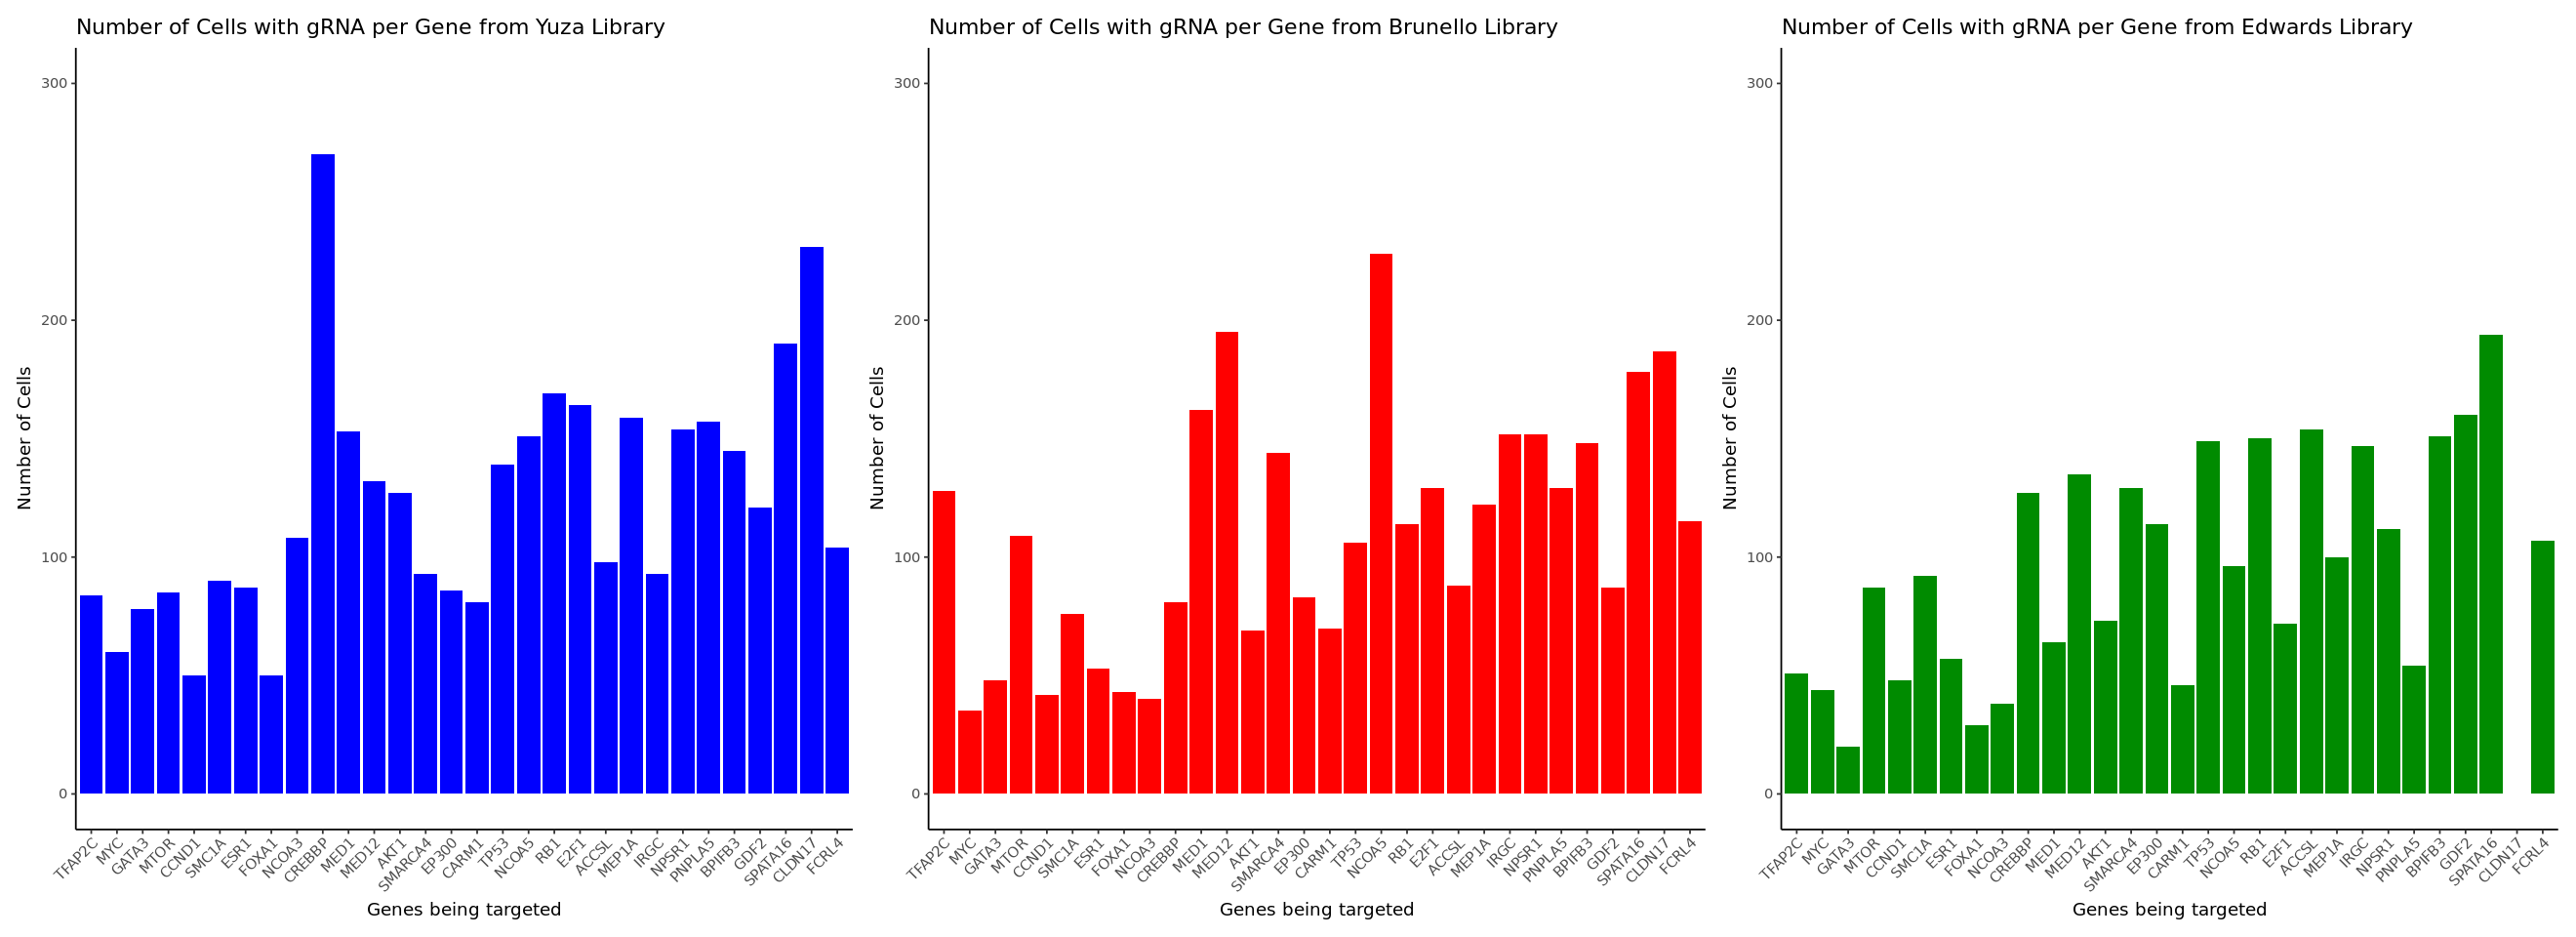

In [35]:
yuza_gene_cell_count | brunello_gene_cell_count | edwards_gene_cell_count

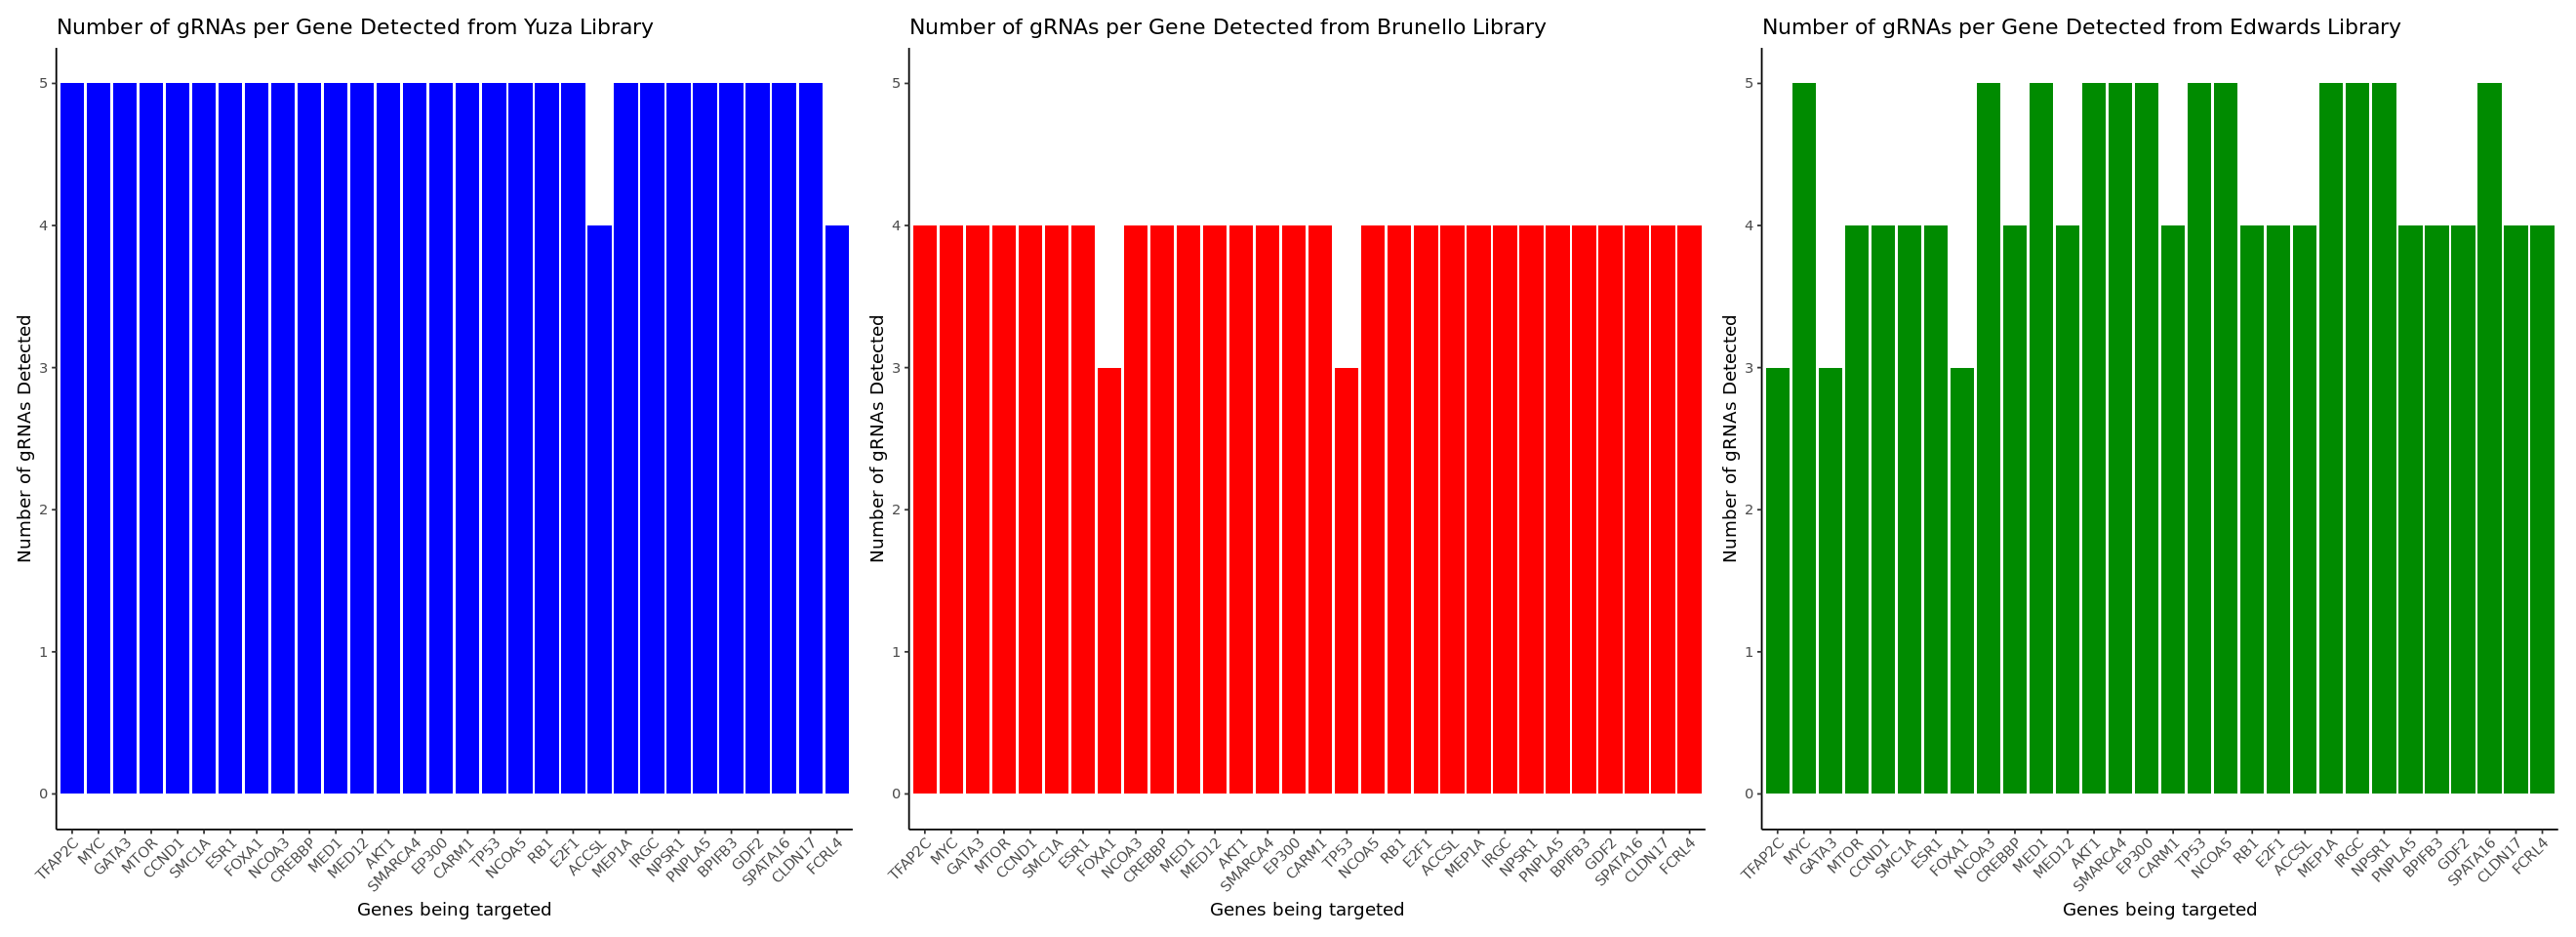

In [36]:
yuza_detected_grnas | brunello_detected_grnas | edwards_detected_grnas

Warning message:
"Removed 1 rows containing missing values (geom_bar)."


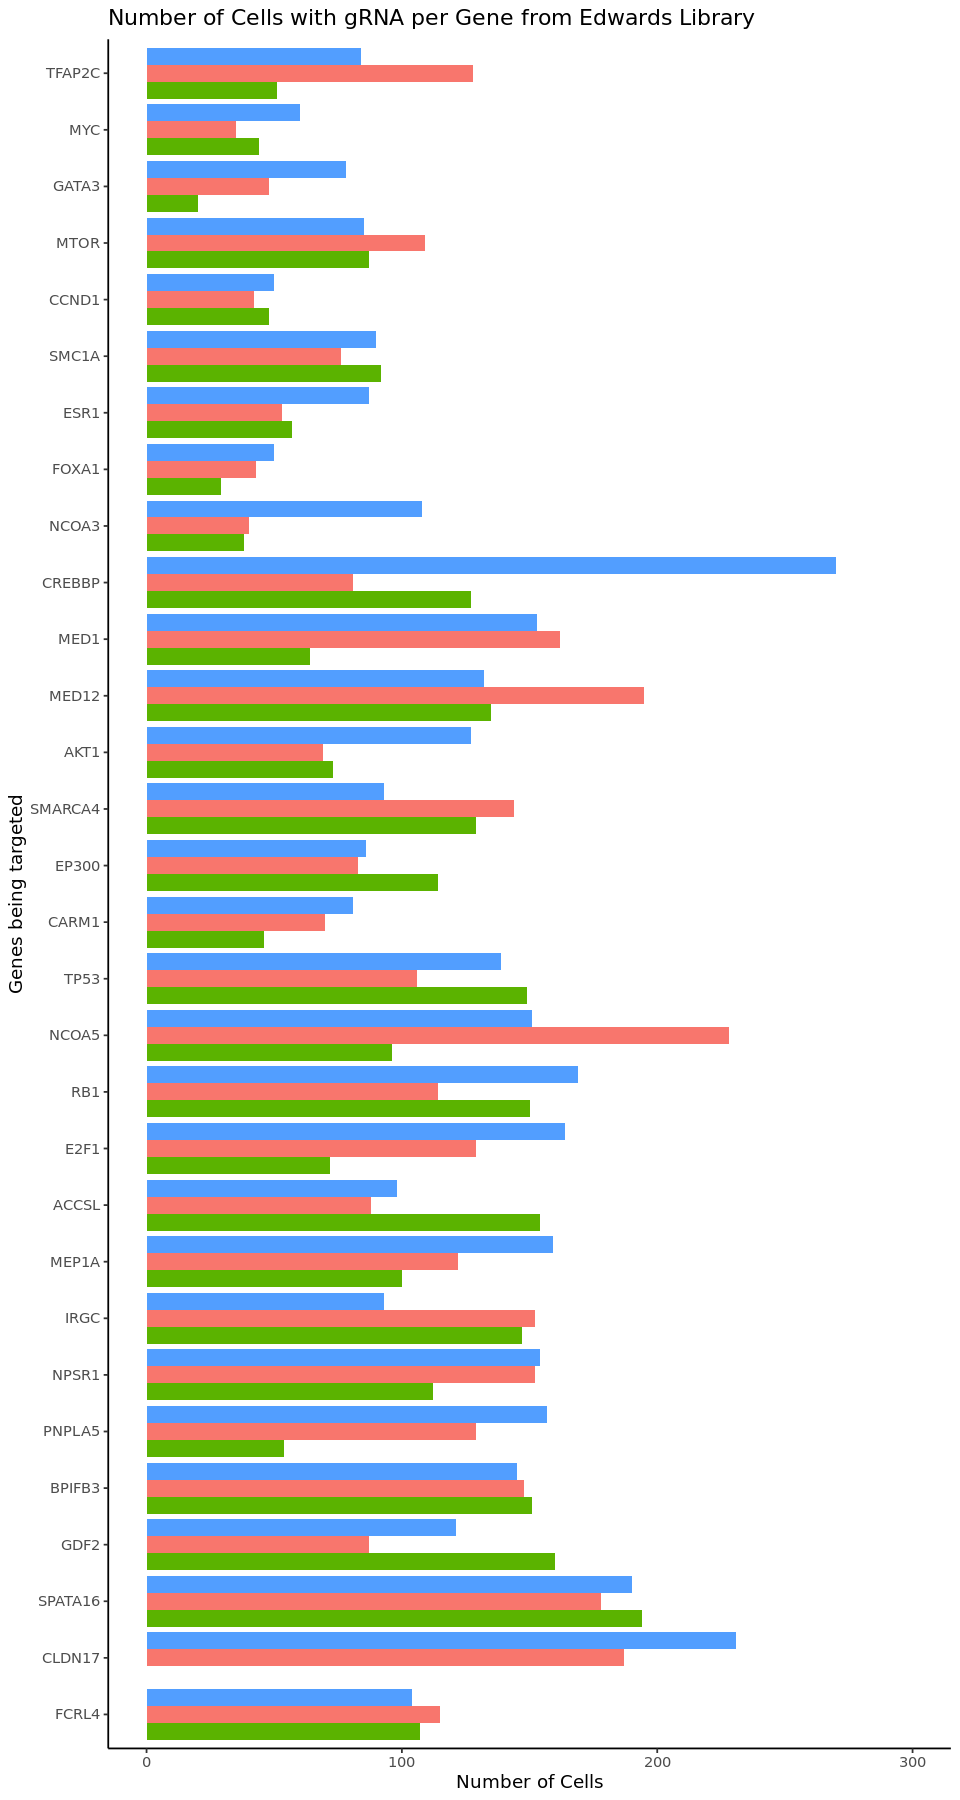

In [37]:
options(repr.plot.width=8, repr.plot.height=15)
merged_gene_cell_count

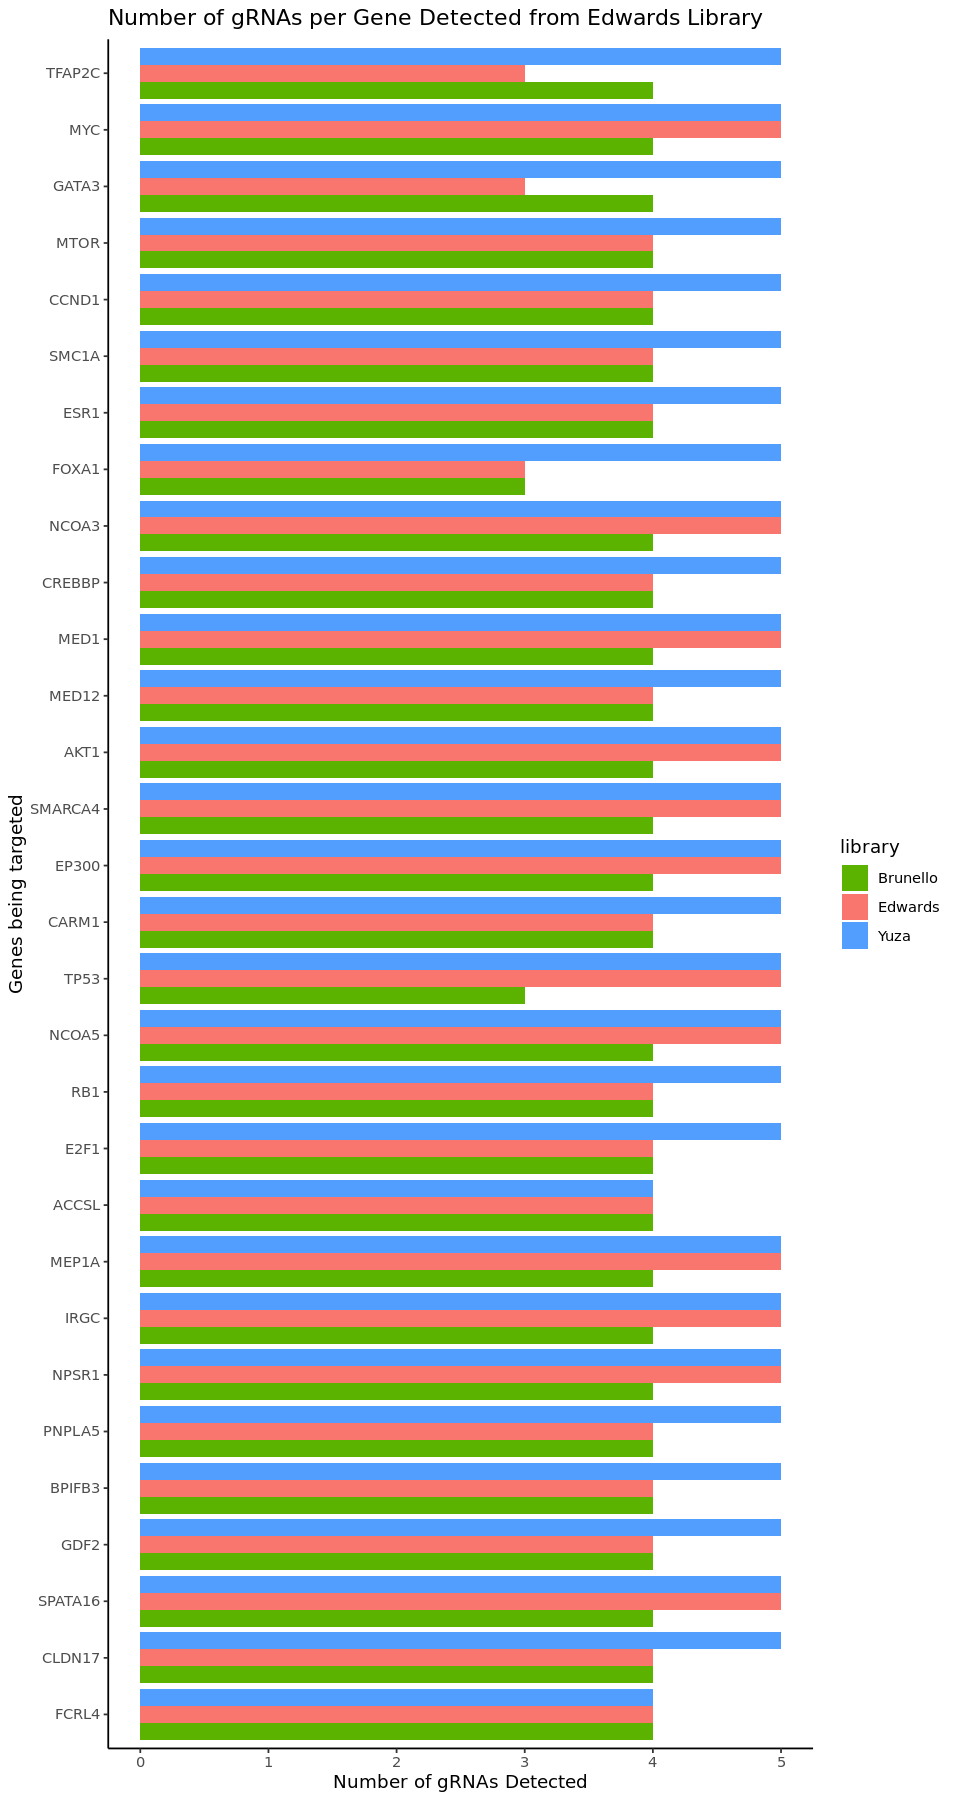

In [38]:
options(repr.plot.width=8, repr.plot.height=15)
merged_detected_grnas

In [39]:
ggsave("num_of_grnas_detected_per_gene_barplot.eps", plot=merged_detected_grnas, height=6, width=6, units="in",device = "eps")
ggsave("num_of_cells_detected_per_gene_barplot.eps", plot=merged_gene_cell_count, height=6, width=6, units="in",device = "eps")

## Number of Cells per gRNA

One important aspect of our downstream anaylsis is that we assess the effeciency of individual gRNAs. In order to conduct this analysis we need to assess the number of cells per gRNA. As you can see in the plots below there are vary number of cells that contain a given gRNA with that max number of cells with a gRNA being around 20-30 cells.

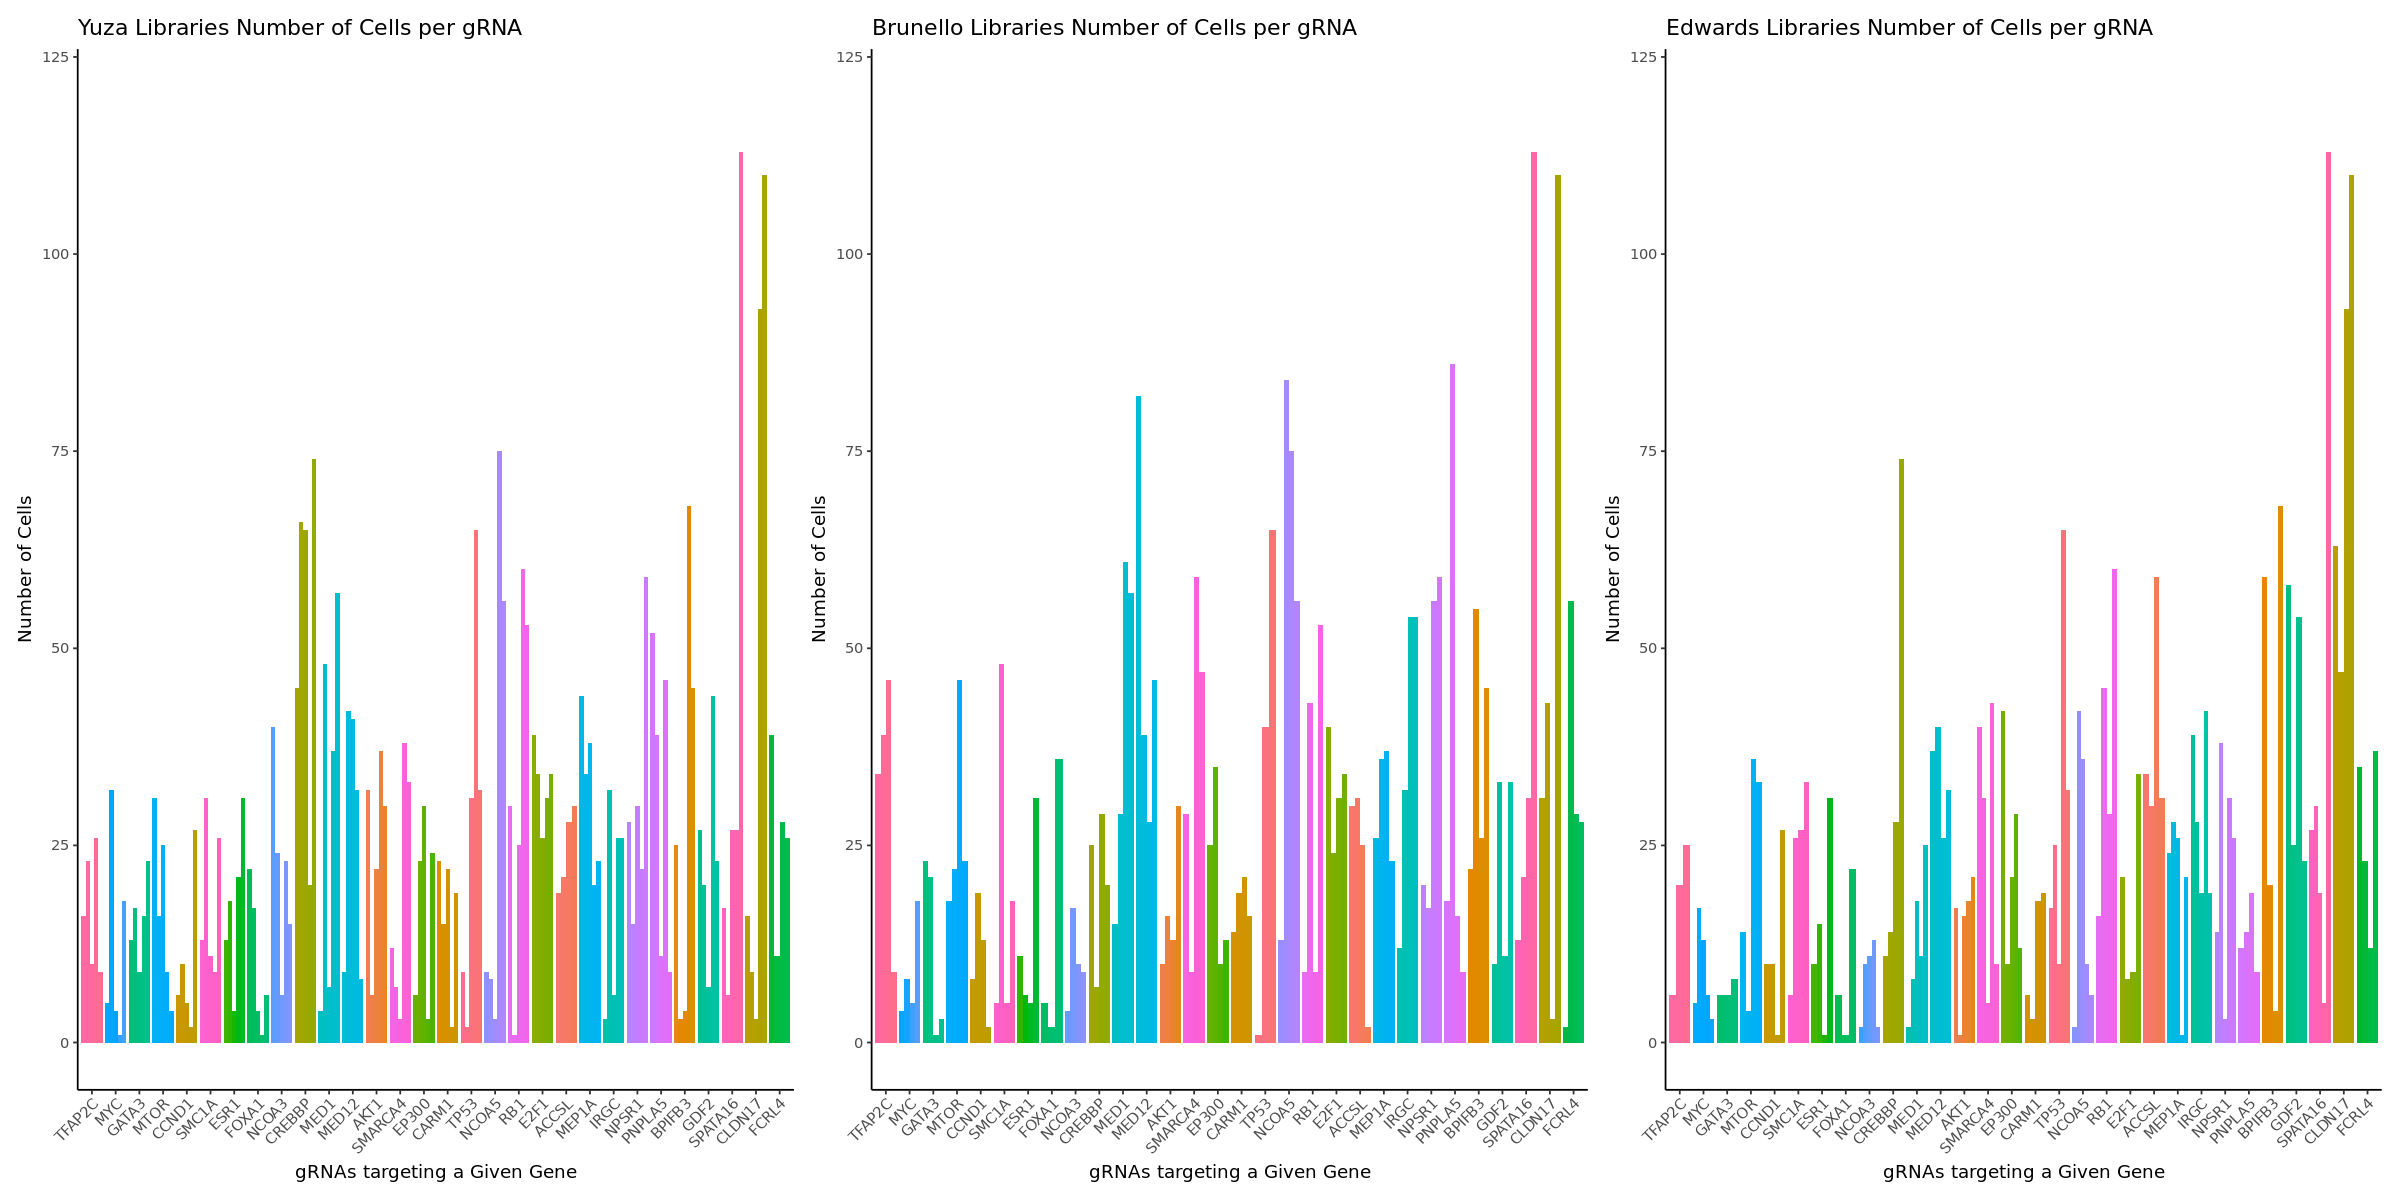

In [43]:
options(repr.plot.width=20, repr.plot.height=10)

yuza_grna_count = yuza %>%
                        dplyr::filter(!library %in% c('Control')) %>% 
                        group_by(library, gene, grna_name) %>% 
                        tally() %>% 
                        ggplot(aes(x=gene, y=n, fill=grna_name)) + 
                        geom_col(position="dodge") + 
                        theme_bw() +
                        theme(plot.background = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              panel.border = element_blank(),
                              axis.line = element_line(color = 'black'),
                              axis.text.x = element_text(angle = 45, hjust = 1),
                              legend.position='none') +
                        ylim(0, 120) +
                        labs(y='Number of Cells', x='gRNAs targeting a Given Gene', title='Yuza Libraries Number of Cells per gRNA')

edwards_grna_count = edwards %>%
                        dplyr::filter(!library %in% c('Control')) %>% 
                        group_by(library, gene, grna_name) %>% 
                        tally() %>% 
                        ggplot(aes(x=gene, y=n, fill=grna_name)) + geom_col(position="dodge") + 
                        theme_bw() +
                        theme(plot.background = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              panel.border = element_blank(),
                              axis.line = element_line(color = 'black'),
                              axis.text.x = element_text(angle = 45, hjust = 1),
                              legend.position='none') +
                        ylim(0, 120) +
                        labs(y='Number of Cells', x='gRNAs targeting a Given Gene', title='Edwards Libraries Number of Cells per gRNA')

brunello_grna_count = brunello %>%
                        dplyr::filter(!library %in% c('Control')) %>% 
                        group_by(library, gene, grna_name) %>% 
                        tally() %>% 
                        ggplot(aes(x=gene, y=n, fill=grna_name)) + geom_col(position="dodge") + 
                        theme_bw() +
                        theme(plot.background = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              panel.border = element_blank(),
                              axis.line = element_line(color = 'black'),
                              axis.text.x = element_text(angle = 45, hjust = 1),
                              legend.position='none') +
                        ylim(0, 120) +
                        labs(y='Number of Cells', x='gRNAs targeting a Given Gene', title='Brunello Libraries Number of Cells per gRNA')

yuza_grna_count | brunello_grna_count | edwards_grna_count 

In [37]:
ggsave("num_of_cells_detected_per_yuza_grna_barplot.eps", plot=yuza_grna_count, height=6, width=6, units="in",device = "eps")
ggsave("num_of_cells_detected_per_brunello_grna_barplot.eps", plot=brunello_grna_count, height=6, width=6, units="in",device = "eps")
ggsave("num_of_cells_detected_per_edwards_grna_barplot.eps", plot=edwards_grna_count, height=6, width=6, units="in",device = "eps")

## Saving Rds Objects from all Libraries

In [44]:
saveRDS(yuza_sce, paste0(data_dir, "/SCE/Yuza.Rds"))
saveRDS(edwards_sce, paste0(data_dir, "/SCE/Edwards.Rds"))
saveRDS(brunello_sce, paste0(data_dir, "/SCE/Brunello.Rds" ))
saveRDS(sce, paste0(data_dir, "/SCE/Merged.Rds"))